## Evaluation and Comparison of Network-based and Sequence-based comparison methods.

The purpose of this notebook is to compare the effectiveness of the Network-based link prediction method (GLIDE) and compare it against the Sequence-based comparison methods.

More formally, If the target organism already has an evident PPI network, do network-based approaches work better to predict the remaining edges, compared to the sequence based approaches like D-SCRIPT? 

We devise two experiments for this purpose:

1. The first method tries to analyze the effect of the target PPI network **sparsity** on the Network-based method.    At which sparsity does the Network-based link prediction method is outperformed by D-SCRIPT?

2. Is D-SCRIPT better (or worse) at predicting the links between two nodes that are far apart (in shortest distances) than the Network-based method. Our hypothesis is that D-SCRIPT becomes more effective in predicting far-apart nodes than Network-based methods.

### 1) Preprocessing: GLIDE computations

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
import json
import networkx as nx

In [3]:
# Checking if the original network is connected
G = nx.read_edgelist("data/network.tsv")
nx.is_connected(G)
largest_cc = max(nx.connected_components(G), key=len)
S          = G.subgraph(largest_cc).copy()
node_set   = set(S.nodes())
nx.write_edgelist(S, "data/network_c.tsv", delimiter="\t", data = False)

In [ ]:
# Since the graph is not connected, extract the largest component and generate the subgraph

In [32]:
# Sparsify the networks: Create subnets with the spanning tree intact, removing from 0.1 to 0.8
# times the original number of edges. Save it to data/subnets
# ! mkdir data/subnets

# Uses the create_subnet.py file
# USAGE: python create_subnet.py --network=<netfile> --perc=<value between 0 and 1> --output=<output_file>
#! rm data/subnets/*
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print(f"Running Subnet with PERC={i}")
    !python create_subnet.py --network=data/network_c.tsv --perc={i} --output=data/subnets/network_{i}.tsv


Running Subnet with PERC=0.1
Running Subnet with PERC=0.2
Running Subnet with PERC=0.3
Running Subnet with PERC=0.4
Running Subnet with PERC=0.5
Running Subnet with PERC=0.6
Running Subnet with PERC=0.7
Running Subnet with PERC=0.8


In [33]:
# Running GLIDE to get GLIDE mat and GLIDE map for the networks; in data/subnets

# Uses the compute_glide_mat.py function
# USAGE: python compute_glide_mat.py --network=<netfile> --output_mat=<output_glide_file> --output_json=<output_json_file>

for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print(f"Running GLIDE for Subnet with PERC={i}")
    !python compute_glide_mat.py --network=data/subnets/network_{i}.tsv --output_mat=data/subnets/network_{i}.npy --output_json=data/subnets/network_{i}.json

Running GLIDE for Subnet with PERC=0.1
Running GLIDE for Subnet with PERC=0.2
Running GLIDE for Subnet with PERC=0.3
Running GLIDE for Subnet with PERC=0.4
Running GLIDE for Subnet with PERC=0.5
Running GLIDE for Subnet with PERC=0.6
Running GLIDE for Subnet with PERC=0.7
Running GLIDE for Subnet with PERC=0.8


## 2) Generating Datasets for evaluation


Since it is infeasible to find the D-SCRIPT scores of all the node-pairs in the network, we randomly select a large but incomplete set of node-pairs and compute D-SCRIPT on it. Then,  we add the D-SCRIPT scores for the true edges and mix the two of them together.

In [4]:
# Dataset construction: Generate the complete network file from the D-SCRIPT prediction 

# Get all positive pairs from the file DSCRIPT-Results/fly...
df_net   = pd.read_csv("DSCRIPT-Results/fly_BIND_PPIs_dscript.tsv", header = None, sep = "\t")
df_net   = df_net.loc[(df_net[0].isin(node_set)) & (df_net[1].isin(node_set))]

# Get all random pairs from the file "data/dmela_10M_candidates_20201018_f3e7_predictions.txt"
df_randpairs = pd.read_csv("data/dmela_10M_candidates_20201018_f3e7_predictions.txt", header = None, sep = "\t")
df_randpairs = df_randpairs.loc[(df_randpairs[0].isin(node_set)) & (df_randpairs[1].isin(node_set))]

# print("All the nodes are:")
# print(node_set)
print(f"Length: {len(node_set)}")

Length: 3093


0                 1         2
0      7227.FBpp0083802  7227.FBpp0291653  0.898801
1      7227.FBpp0074431  7227.FBpp0086820  0.004207
2      7227.FBpp0074554  7227.FBpp0082513  0.394838
3      7227.FBpp0070646  7227.FBpp0076990  0.004177
4      7227.FBpp0081592  7227.FBpp0087450  0.004201
...                 ...               ...       ...
27465  7227.FBpp0070422  7227.FBpp0080629  0.004178
27466  7227.FBpp0072975  7227.FBpp0078847  0.987240
27467  7227.FBpp0081380  7227.FBpp0110438  0.985707
27468  7227.FBpp0071049  7227.FBpp0083503  0.004253
27469  7227.FBpp0070402  7227.FBpp0082973  0.971406

[27134 rows x 3 columns]

In [7]:
# The first node in this dataset is alphabetically smaller than the second node
# Add the random node-pairs with true network nodes
net_df    = df_net.copy()
rand_df   = df_randpairs.copy()

net_df[3]  = np.ones(len(net_df))
rand_df[3] = np.zeros(len(rand_df))

all_df = pd.concat([net_df, rand_df])
all_df[2] = all_df.drop([3], axis = 1).groupby([0,1]).transform(np.mean)
all_df[3] = all_df.drop([2], axis = 1).groupby([0,1]).transform('max')
all_df    = all_df.drop_duplicates()
all_df.columns=["node1", "node2", "DSCRIPT-score", "True_score"]
all_df.to_csv("data/all_nodepairs.tsv", sep = "\t", index=False)

In [8]:
!wc -l data/all_nodepairs.tsv

294308 data/all_nodepairs.tsv


## 1. Dealing with sparsity - Analysis of D-SCRIPT and GLIDE methods

#### 1.1 Compute the p-hat, PR and ROC curves for the D-SCRIPT method

In [9]:
df = pd.read_csv("data/all_nodepairs.tsv", sep = "\t")
df_gd = pd.read_csv("data/all_nodepairs_GDSCRIPT.tsv", sep = "\t")

df.loc[df["node1"] > df["node2"]] = df.loc[df["node1"] > df["node2"], ["node2", "node1", "DSCRIPT-score", "True_score"]].values
df_gd.loc[df_gd["node1"] > df_gd["node2"]] = df_gd.loc[df_gd["node1"] > df_gd["node2"], ["node2", "node1", "True_score", "G-DSCRIPT-score"]].values 

def trim_df(df, edges_to_remove_file):
    """
    Used to trim the complete dataset, in order to remove certain edges from the file df, where the edges to 
    remove are placed in edges_to_remove_file.
    """
    network = pd.read_csv(edges_to_remove_file, sep = "\t", header = None)
    network = network.rename(columns={0:"node1", 1:"node2"})
    # Fix the nodes
    network.loc[network["node1"] > network["node2"], ["node1", "node2"]] = network.loc[network["node1"] > network["node2"], ["node2", "node1"]].values
    trimmed = pd.merge(df,network, indicator=True, on=["node1", "node2"],
                       how='outer').query('_merge == "left_only"').drop("_merge", 1)
    return trimmed

df = df.merge(df_gd, how = "inner", on = ["node1", "node2", "True_score"])
df

#net = pd.read_csv("data/subnets/network_0.2.tsv", sep = "\t", header = None)
#net.columns=["node1", "node2"]
#mg = df.merge(net, how = "inner", on = ["node1", "node2"])
#mg.loc[df["True_score"] < 0.5]

node1             node2  DSCRIPT-score  True_score  \
0       7227.FBpp0083802  7227.FBpp0291653       0.898801         1.0   
1       7227.FBpp0074431  7227.FBpp0086820       0.004207         1.0   
2       7227.FBpp0070646  7227.FBpp0076990       0.004177         1.0   
3       7227.FBpp0081592  7227.FBpp0087450       0.004201         1.0   
4       7227.FBpp0075395  7227.FBpp0078400       0.010203         1.0   
...                  ...               ...            ...         ...   
292595  7227.FBpp0072425  7227.FBpp0082318       0.004471         0.0   
292596  7227.FBpp0081526  7227.FBpp0088565       0.004178         0.0   
292597  7227.FBpp0075618  7227.FBpp0079812       0.135222         0.0   
292598  7227.FBpp0080279  7227.FBpp0080926       0.004177         0.0   
292599  7227.FBpp0073988  7227.FBpp0086919       0.004178         0.0   

        G-DSCRIPT-score  
0              0.922090  
1              0.687090  
2              0.624810  
3              0.207470  
4              0.672320  
...                 ...  
292595         0.000459  
292596         0.002009  
292597         0.202460  
292598         0.000301  
292599         0.000061  

[292600 rows x 5 columns]

In [78]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
aupr_d = average_precision_score(df["True_score"], df["DSCRIPT-score"])
aupr_g = average_precision_score(df["True_score"], df["G-DSCRIPT-score"])

auc_d  = roc_auc_score(df["True_score"], df["DSCRIPT-score"])
auc_g  = roc_auc_score(df["True_score"], df["G-DSCRIPT-score"])
print(aupr_d)
print(aupr_g)
print(auc_d)
print(auc_g)

0.35571597195711724
0.5376576116993484
0.7605068775650435
0.8844634783595786


In [12]:
def get_glide_scores(fnodemap, fnodejs, df):
    glidemat = np.load(fnodemap)
    gscores  = []
    with open(fnodejs, "r") as jf:
        glidemap = json.load(jf)
    for index, row in df.iterrows():
        node1 = glidemap[row["node1"]]        
        node2 = glidemap[row["node2"]]
        gscores.append(glidemat[node1, node2])
    return np.array(gscores) / np.max(gscores)


In [10]:
print("Trimming Edges from DSCRIPT dataset")
dfs = {}
dfs["0.2"] = trim_df(df, "data/subnets/network_0.2.tsv")
dfs["0.4"] = trim_df(df, "data/subnets/network_0.4.tsv")
dfs["0.6"] = trim_df(df, "data/subnets/network_0.6.tsv")
dfs["0.8"] = trim_df(df, "data/subnets/network_0.8.tsv")


Trimming Edges from DSCRIPT dataset


/net/scratch3/scratch3-3/kdevko01/miniconda3/envs/dscriptold/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [11]:
for i in ["0.2", "0.4", "0.6", "0.8"]:
    print(f"Neg {1-float(i)}: " + str(len(dfs[i].loc[dfs[i]["True_score"] < 0.5])))
    print(f"Pos {1-float(i)}: " + str(len(dfs[i].loc[dfs[i]["True_score"] > 0.5])))

Neg 0.8: 267173
Pos 0.8: 5085
Neg 0.6: 267173
Pos 0.6: 10183
Neg 0.4: 267173
Pos 0.4: 15287
Neg 0.19999999999999996: 267173
Pos 0.19999999999999996: 20352


In [92]:
print(len(dfs["0.8"].drop_duplicates(["node1", "node2"])))
pd.merge(df, pd.read_csv("data/subnets/network_0.8.tsv", sep = "\t", header = None), left_on = ["node1", "node2"], right_on = [0, 1], how = "inner")["True_score"].describe()

288881


count    2948.000000
mean        0.937246
std         0.242562
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: True_score, dtype: float64

In [13]:

glide_scores   = {}
for i in ["0.2", "0.4", "0.6", "0.8"]:
    print(f"Computing GLIDE results for GLIDE_{i}")
    glide_scores[i]   = get_glide_scores(f"data/subnets/network_{i}.npy", f"data/subnets/network_{i}.json", dfs[i])
    
n_sparsity = {}
n_sparsity["pos"] = []
n_sparsity["neg"] = []
# Add GLIDE scores to the computed dfs
for i in ["0.2", "0.4", "0.6", "0.8"]:
    n_sparsity["pos"].append(len(dfs[i].loc[dfs[i]["True_score"] == 1]))
    n_sparsity["neg"].append(len(dfs[i].loc[dfs[i]["True_score"] == 0]))
    dfs[i][f"GLIDE_{i}_score"] = glide_scores[i]

sparsity_df = pd.DataFrame(n_sparsity, index=["i=0.2", "i=0.4", "i=0.6", "i=0.8"])
sparsity_df.to_csv("data/sparsity_nedges.tsv", sep = "\t")

Computing GLIDE results for GLIDE_0.2
Computing GLIDE results for GLIDE_0.4
Computing GLIDE results for GLIDE_0.6
Computing GLIDE results for GLIDE_0.8


In [14]:
# Information about the dataset:
import networkx as nx
import numpy as np

n_nodes = ""
n_info={"no_nodes": [], "no_edges": [], "diameter": [], "average_degree": []}
ps=["0.2", "0.4", "0.6", "0.8"]
for i in ps:
    G = nx.read_edgelist(f"data/subnets/network_{i}.tsv")
    degs = [d for v,d in G.degree()]
    n_info["average_degree"].append(np.average(degs))
    n_info["no_nodes"].append(len(G))
    n_info["no_edges"].append(len(G.edges()))
    n_info["diameter"].append(nx.diameter(G))
n_info

{'no_nodes': [3093, 3093, 3093, 3093],
 'no_edges': [21707, 16280, 10853, 5426],
 'diameter': [18, 17, 18, 22],
 'average_degree': [14.036210798577432,
  10.526996443582282,
  7.017782088587132,
  3.508567733591982]}

In [15]:
p="0.8"
dfs_02_p = dfs[p].loc[dfs[p]["True_score"] > 0.5]
dfs_02_n = dfs[p].loc[dfs[p]["True_score"] < 0.5]
dfs_02_p.merge(dfs_02_n, how = "inner", on = ["node1", "node2"])

Empty DataFrame
Columns: [node1, node2, DSCRIPT-score_x, True_score_x, G-DSCRIPT-score_x, GLIDE_0.8_score_x, DSCRIPT-score_y, True_score_y, G-DSCRIPT-score_y, GLIDE_0.8_score_y]
Index: []

In [16]:
n_df = pd.DataFrame(n_info, index = ["0.8", "0.6", "0.4", "0.2"])
n_df.to_csv("network_info.tsv", sep = "\t")

In [44]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
gp = dict()
gr = dict()
dp = dict()
dr = dict()
dgp = dict()
dgr = dict()
aupr_g = dict()
aupr_d = dict()
aupr_gd = dict()
average_precision = dict()
sparsity_res = {"GLIDE-AUPR": [], "D-SCRIPT-AUPR": [], "LEND-SCRIPT-AUPR": []}
for i in ["0.2", "0.4", "0.6", "0.8"]:
    gp[i], gr[i], _   = precision_recall_curve(dfs[i]["True_score"].tolist(), glide_scores[i])
    aupr_g[i]         = average_precision_score(dfs[i]["True_score"].tolist(), glide_scores[i])
    dp[i], dr[i], _   = precision_recall_curve(dfs[i]["True_score"].tolist(), dfs[i]["DSCRIPT-score"].tolist())
    aupr_d[i]         = average_precision_score(dfs[i]["True_score"].tolist(), dfs[i]["DSCRIPT-score"].tolist())
    dgp[i], dgr[i], _ = precision_recall_curve(dfs[i]["True_score"].tolist(), dfs[i]["G-DSCRIPT-score"].tolist())
    aupr_gd[i]        = average_precision_score(dfs[i]["True_score"].tolist(), dfs[i]["G-DSCRIPT-score"].tolist())
    sparsity_res["GLIDE-AUPR"].append(aupr_g[i])
    sparsity_res["D-SCRIPT-AUPR"].append(aupr_d[i])
    sparsity_res["LEND-SCRIPT-AUPR"].append(aupr_gd[i])

df_sparsity = pd.DataFrame(sparsity_res, index = ["0.2", "0.4", "0.6", "0.8"])
df_sparsity.to_csv("Tables/sparsity_aupr.tsv", sep = "\t")

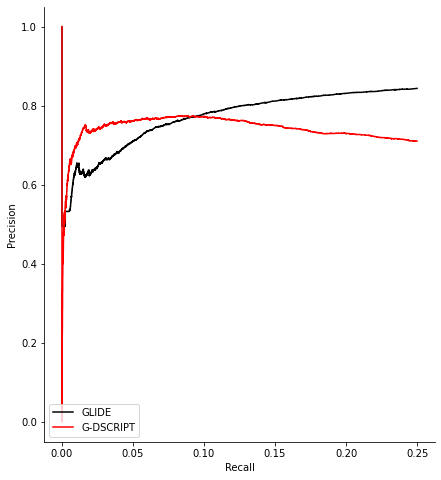

In [69]:
dir1 = "data/results/sparsity"
#!mkdir data_HURI/results
#!mkdir data/results/sparsity
rec = 0.25
for i in ["0.8"]:#, "0.4", "0.6", "0.8"]:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    fig = plt.figure(figsize=(7,8)) #whatever size you want
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    display = PrecisionRecallDisplay(
            recall=gr[i][gr[i] < rec],
            precision=gp[i][gr[i] < rec])
    display.plot(ax=ax, name=f"GLIDE", # (AUPR-{aupr_g[i]})", 
                 color="black")
#    display = PrecisionRecallDisplay(
#            recall=dr[i][dr[i] < rec],
#            precision=dp[i][dr[i] < rec])
#    display.plot(ax=ax, name=f"D-SCRIPT", #(AUPR-{aupr_d[i]})", 
#                 color = "blue")
    display = PrecisionRecallDisplay(
            recall=dgr[i][dgr[i] < rec],
            precision=dgp[i][dgr[i] < rec])
    display.plot(ax=ax, name=f"G-DSCRIPT", # (AUPR-{aupr_gd[i]})", 
                 color = "red")
    fig.savefig(f"Tables/aupr_p_{i}.svg", bbox_inches="tight")

In [18]:
for i in ["0.2", "0.4", "0.6", "0.8"]:
    ratio = len(dfs[i].loc[dfs[i]["True_score"] == 1]) / float(len(dfs[i]))
    print(f"The positive/total ratio for p = {i} is {ratio}" )

The positive/total ratio for p = 0.2 is 0.01867713712728368
The positive/total ratio for p = 0.4 is 0.03671454736872467
The positive/total ratio for p = 0.6 is 0.05412093747787297
The positive/total ratio for p = 0.8 is 0.07078341013824885


## Experiment 2: How does the distance between the nodes in the network affect effectiveness in Function Prediction

1) For this, I only considered the network "network_0.8.txt" (Call it G) (80% edges removed).

2) For the removed edges (80% of the whole network), I separated them by their shortest distances in G (E_2, E_3, E_4, ...) (Where E_i is the list of edges with shortest distances = i in G).

3) From the random list, select negative samples (F_1, F_2, ...). 


In [19]:
Gs             = {}
Gs["complete"] = nx.read_edgelist(f"data/network_c.tsv") 
for i in ["0.2", "0.4", "0.6", "0.8"]:
    print(f"Running shortest dist for network {i}")
    shortest_dist = [] 
    Gs[i]     = nx.read_edgelist(f"data/subnets/network_{i}.tsv")
    for index, row in dfs[i].iterrows():
        sd = nx.shortest_path_length(Gs[i], 
                                     source=row["node1"], 
                                     target=row["node2"])
        shortest_dist.append(sd)
    dfs[i]["shortest_dist"] = shortest_dist

Running shortest dist for network 0.2
Running shortest dist for network 0.4
Running shortest dist for network 0.6
Running shortest dist for network 0.8


In [45]:
ks=[2,3,4,5]
ps=["0.2", "0.4", "0.6", "0.8"]
data = {"k=2,pos":[], "k=2,neg":[], "k=3,pos":[], "k=3,neg":[], "k=4,pos":[], "k=4,neg":[], "k=5+,pos":[], "k=5+,neg":[]}
for p in ps:
    for k in ks:
        if k < 5:
            dts = dfs[p].loc[dfs[p]["shortest_dist"] == k]
        else:
            dts = dfs[p].loc[dfs[p]["shortest_dist"] >= k]
        pos = len(dts.loc[dts["True_score"] > 0.5])
        neg = len(dts.loc[dts["True_score"] < 0.5])
        data[f"k={k}" + ("+" if k == 5 else "") + ",pos"].append(pos)
        data[f"k={k}" + ("+" if k == 5 else "") + ",neg"].append(neg)
stdf = pd.DataFrame(data, index = ["0.2", "0.4", "0.6", "0.8"])
stdf.to_csv("Tables/sd_positive_and_negative_edges.tsv", sep = "\t")

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def compute_precision_recall_glide_sdg(df_d, sd, i):
    df_sd = df_d.loc[df_d["shortest_dist"] >= sd]
    true_scores  = df_sd["True_score"].tolist()
    glide_scores   = df_sd[f"GLIDE_{i}_score"].tolist()
    prec_glide, rec_glide, _     = precision_recall_curve(true_scores, glide_scores)
    glide_aupr                   = average_precision_score(true_scores, glide_scores)
    return prec_glide, rec_glide, glide_aupr 

def compute_precision_recall_dscript_sdg(df_d, sd):
    df_sd = df_d.loc[df_d["shortest_dist"] >= sd]
    true_scores  = df_sd["True_score"].tolist()
    dscript_scores = df_sd["DSCRIPT-score"].tolist()
    prec_dscript, rec_dscript, _ = precision_recall_curve(true_scores, dscript_scores)
    dscript_aupr                 = average_precision_score(true_scores, dscript_scores)
    return prec_dscript, rec_dscript, dscript_aupr

def compute_precision_recall_gdscript_sdg(df_d, sd):
    df_sd = df_d.loc[df_d["shortest_dist"] >= sd]
    true_scores  = df_sd["True_score"].tolist()
    dscript_scores = df_sd["G-DSCRIPT-score"].tolist()
    prec_dscript, rec_dscript, _ = precision_recall_curve(true_scores, dscript_scores)
    dscript_aupr                 = average_precision_score(true_scores, dscript_scores)
    return prec_dscript, rec_dscript, dscript_aupr

auprs = {"AUPR-D-SCRIPT:k>=5": [], "AUPR-LEND-SCRIPT:k>=5": [], "AUPR-GLIDE:k>=5": []}
for i in ["0.2", "0.4", "0.6", "0.8"]:
    _, _, aupd  = compute_precision_recall_dscript_sdg(dfs[i], 5)
    _, _, aupg  = compute_precision_recall_glide_sdg(dfs[i], 5, i)
    _, _, aupgd = compute_precision_recall_gdscript_sdg(dfs[i], 5)
    auprs["AUPR-D-SCRIPT:k>=5"].append(aupd)
    auprs["AUPR-LEND-SCRIPT:k>=5"].append(aupgd)
    auprs["AUPR-GLIDE:k>=5"].append(aupg)

dauprs = pd.DataFrame(auprs, index = ["0.8", "0.6", "0.4", "0.2"])
dauprs.to_csv("sdgreaterthan5.aupr.tsv", sep = "\t")
print(dauprs)
def compute_precision_recall_glide_sd(df_d, sd, i):
    df_sd = df_d.loc[df_d["shortest_dist"] == sd]
    true_scores  = df_sd["True_score"].tolist()
    glide_scores   = df_sd[f"GLIDE_{i}_score"].tolist()
    prec_glide, rec_glide, _     = precision_recall_curve(true_scores, glide_scores)
    glide_aupr                   = average_precision_score(true_scores, glide_scores)
    return prec_glide, rec_glide, glide_aupr 

def compute_precision_recall_dscript_sd(df_d, sd):
    df_sd = df_d.loc[df_d["shortest_dist"] == sd]
    true_scores  = df_sd["True_score"].tolist()
    dscript_scores = df_sd["DSCRIPT-score"].tolist()
    prec_dscript, rec_dscript, _ = precision_recall_curve(true_scores, dscript_scores)
    dscript_aupr                 = average_precision_score(true_scores, dscript_scores)
    return prec_dscript, rec_dscript, dscript_aupr

def compute_precision_recall_gdscript_sd(df_d, sd):
    df_sd = df_d.loc[df_d["shortest_dist"] == sd]
    true_scores  = df_sd["True_score"].tolist()
    dscript_scores = df_sd["G-DSCRIPT-score"].tolist()
    prec_dscript, rec_dscript, _ = precision_recall_curve(true_scores, dscript_scores)
    dscript_aupr                 = average_precision_score(true_scores, dscript_scores)
    return prec_dscript, rec_dscript, dscript_aupr

def compute_roc_glide_sd(df_d, sd, i):
    df_sd = df_d.loc[df_d["shortest_dist"] == sd]
    true_scores  = df_sd["True_score"].tolist()
    glide_scores   = df_sd[f"GLIDE_{i}_score"].tolist()
    fp_glide, tp_glide, _  = roc_curve(true_scores, glide_scores)
    glide_auroc            = roc_auc_score(true_scores, glide_scores)
    return tp_glide, fp_glide, glide_auroc 

def compute_roc_dscript_sd(df_d, sd):
    df_sd = df_d.loc[df_d["shortest_dist"] == sd]
    true_scores  = df_sd["True_score"].tolist()
    dscript_scores = df_sd["DSCRIPT-score"].tolist()
    fp_dscript, tp_dscript, _ = roc_curve(true_scores, dscript_scores)
    dscript_auroc             = roc_auc_score(true_scores, dscript_scores)
    return tp_dscript, fp_dscript, dscript_auroc

def compute_roc_gdscript_sd(df_d, sd):
    df_sd = df_d.loc[df_d["shortest_dist"] == sd]
    true_scores  = df_sd["True_score"].tolist()
    dscript_scores = df_sd["G-DSCRIPT-score"].tolist()
    fp_dscript, tp_dscript, _ = roc_curve(true_scores, dscript_scores)
    dscript_auroc             = roc_auc_score(true_scores, dscript_scores)
    return tp_dscript, fp_dscript, dscript_auroc

def compute_roc_glide_sdg(df_d, sd, i):
    df_sd = df_d.loc[df_d["shortest_dist"] >= sd]
    true_scores  = df_sd["True_score"].tolist()
    glide_scores   = df_sd[f"GLIDE_{i}_score"].tolist()
    fp_glide, tp_glide, _  = roc_curve(true_scores, glide_scores)
    glide_auroc            = roc_auc_score(true_scores, glide_scores)
    return tp_glide, fp_glide, glide_auroc 

def compute_roc_dscript_sdg(df_d, sd):
    df_sd = df_d.loc[df_d["shortest_dist"] >= sd]
    true_scores  = df_sd["True_score"].tolist()
    dscript_scores = df_sd["DSCRIPT-score"].tolist()
    fp_dscript, tp_dscript, _ = roc_curve(true_scores, dscript_scores)
    dscript_auroc             = roc_auc_score(true_scores, dscript_scores)
    return tp_dscript, fp_dscript, dscript_auroc

def compute_roc_gdscript_sdg(df_d, sd):
    df_sd = df_d.loc[df_d["shortest_dist"] >= sd]
    true_scores  = df_sd["True_score"].tolist()
    dscript_scores = df_sd["G-DSCRIPT-score"].tolist()
    fp_dscript, tp_dscript, _ = roc_curve(true_scores, dscript_scores)
    dscript_auroc             = roc_auc_score(true_scores, dscript_scores)
    return tp_dscript, fp_dscript, dscript_auroc



     AUPR-D-SCRIPT:k>=5  AUPR-LEND-SCRIPT:k>=5  AUPR-GLIDE:k>=5
0.8            0.000711               0.000263         0.000370
0.6            0.000967               0.001956         0.000988
0.4            0.003760               0.011205         0.003572
0.2            0.012377               0.031181         0.011276


In [94]:
results = {}
gps     = {}
grs     = {}
gdps    = {}
gdrs    = {}
dps     = {}
drs     = {}
gtp     = {}
gfp     = {}
dtp     = {}
dfp     = {}
gdtp    = {}
gdfp    = {}

results_sd = {"p=0.2": [], "p=0.4": [], "p=0.6": [], "p=0.8": []}
fpr_recall_sd1 = {"p=0.2": [], "p=0.4": [], "p=0.6": [], "p=0.8": []}
fpr_recall_sd5 = {"p=0.2": [], "p=0.4": [], "p=0.6": [], "p=0.8": []}

indx      = []

def compute_fpr_at_recall(tp, fp, recall):
    low_rc  = 0
    high_rc = 0
    low_fp  = 0
    high_fp = 0
    for (rc, fc) in zip(tp, fp):
        if rc >= recall:
            high_rc = rc
            high_fp = fc
            break
        else:
            low_rc  = rc
            low_fc  = fc
    t       = (recall - low_rc) / (high_rc - low_rc)
    fp      = low_fp + t * (high_fp - low_fp)
    return fp


for j in range(2, 6):
    if j < 5:
        cprd  = compute_precision_recall_dscript_sd
        cprg  = compute_precision_recall_glide_sd
        cprgd = compute_precision_recall_gdscript_sd
        crocd = compute_roc_dscript_sd
        crocg = compute_roc_glide_sd
        crocgd = compute_roc_gdscript_sd
    else:
        cprd  = compute_precision_recall_dscript_sdg
        cprg  = compute_precision_recall_glide_sdg
        cprgd = compute_precision_recall_gdscript_sdg
        crocd = compute_roc_dscript_sdg
        crocg = compute_roc_glide_sdg
        crocgd = compute_roc_gdscript_sdg
    ipref  = f"k" + (">=" if j ==5 else "=") + f"{j}"    
    indx += [ipref+":D-SCRIPT", ipref + ":GLIDE", ipref + ":LEND-SCRIPT"]

    for i in ["0.2", "0.4", "0.6", "0.8"]:     
        dps[f"{i}:{j}"], drs[f"{i}:{j}"], dap = cprd(dfs[i], j)
        results[f"dscript_{i}"]               = ([dap] if f"dscript_{i}" not in results 
                                                else results[f"dscript_{i}"] + [dap])
        gps[f"{i}:{j}"], grs[f"{i}:{j}"], dag = cprg(dfs[i], j, i)
        results[f"GLIDE_{i}"]                 = ([dag] if f"GLIDE_{i}" not in results 
                                                else results[f"GLIDE_{i}"] + [dag])
        gdps[f"{i}:{j}"], gdrs[f"{i}:{j}"],dagp = cprgd(dfs[i], j)
        results[f"gdscript_{i}"]               = ([dagp] if f"gdscript_{i}" not in results 
                                                else results[f"gdscript_{i}"] + [dagp])
        results_sd[f"p={i}"] += [dap, dag, dagp]
        
        dtp[f"{i}:{j}"], dfp[f"{i}:{j}"], _   = crocd(dfs[i], j)
        gtp[f"{i}:{j}"], gfp[f"{i}:{j}"], _   = crocg(dfs[i], j, i)
        gdtp[f"{i}:{j}"], gdfp[f"{i}:{j}"], _ = crocgd(dfs[i], j)
        fpd1   = compute_fpr_at_recall(dtp[f"{i}:{j}"], dfp[f"{i}:{j}"], 0.10)
        fpd5   = compute_fpr_at_recall(dtp[f"{i}:{j}"], dfp[f"{i}:{j}"], 0.50)
        fpg1   = compute_fpr_at_recall(gtp[f"{i}:{j}"], gfp[f"{i}:{j}"], 0.10)
        fpg5   = compute_fpr_at_recall(gtp[f"{i}:{j}"], gfp[f"{i}:{j}"], 0.50)
        fpgd1  = compute_fpr_at_recall(gdtp[f"{i}:{j}"], gdfp[f"{i}:{j}"], 0.10)
        fpgd5  = compute_fpr_at_recall(gdtp[f"{i}:{j}"], gdfp[f"{i}:{j}"], 0.50)
        fpr_recall_sd1[f"p={i}"] += [fpd1, fpg1, fpgd1]
        fpr_recall_sd5[f"p={i}"] += [fpd5, fpg5, fpgd5]
        
        
dfsdres = pd.DataFrame(results_sd, index = indx).T
dfsdres.to_csv("Tables/shortest_Dist_AUPR.tsv", sep = "\t")
dfsdres
dfsdfp1 = pd.DataFrame(fpr_recall_sd1, index = indx).T
dfsdfp1.to_csv("Tables/shortest_dist_fpr_recall_0.1.tsv", sep = "\t")
dfsdfp5 = pd.DataFrame(fpr_recall_sd5, index = indx).T
dfsdfp5.to_csv("Tables/shortest_dist_fpr_recall_0.5.tsv", sep = "\t")
dfsdres

k=2:D-SCRIPT  k=2:GLIDE  k=2:LEND-SCRIPT  k=3:D-SCRIPT  k=3:GLIDE  \
p=0.2      0.516979   0.837050         0.550675      0.018431   0.118617   
p=0.4      0.715944   0.884737         0.741227      0.058379   0.137900   
p=0.6      0.837632   0.876316         0.852925      0.138501   0.261259   
p=0.8      0.916155   0.825661         0.922244      0.483657   0.670298   

       k=3:LEND-SCRIPT  k=4:D-SCRIPT  k=4:GLIDE  k=4:LEND-SCRIPT  \
p=0.2         0.026086      0.003955   0.001658         0.015902   
p=0.4         0.078102      0.006028   0.004174         0.007278   
p=0.6         0.184657      0.023437   0.011193         0.025305   
p=0.8         0.543860      0.073457   0.133798         0.117195   

       k>=5:D-SCRIPT  k>=5:GLIDE  k>=5:LEND-SCRIPT  
p=0.2       0.000711    0.000370          0.000263  
p=0.4       0.000967    0.000988          0.001956  
p=0.6       0.003760    0.003572          0.011205  
p=0.8       0.012377    0.011276          0.031181

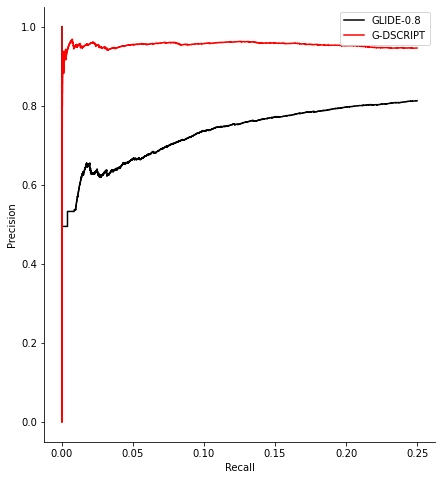

In [77]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig = plt.figure(figsize=(7,8)) #whatever size you want
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

i = "0.8"
sd = 2
rec = 0.25
display = PrecisionRecallDisplay(
            recall=grs[f"{i}:{sd}"][grs[f"{i}:{sd}"] < rec],
            precision=gps[f"{i}:{sd}"][grs[f"{i}:{sd}"] < rec])

display.plot(ax=ax, 
             name=f'GLIDE-{i}', #' (AUPR-{results[f"GLIDE_{i}"][sd - 2]})', 
             color="black")
# display = PrecisionRecallDisplay(
#             recall=drs[f"{i}:{sd}"][drs[f"{i}:{sd}"] < rec],
#             precision=dps[f"{i}:{sd}"][drs[f"{i}:{sd}"] < rec])
# display.plot(ax=ax, 
#              name=f'D-SCRIPT', # (AUPR-{results[f"dscript_{i}"][sd - 2]})', 
#              color = "blue")
display = PrecisionRecallDisplay(
            recall=gdrs[f"{i}:{sd}"][gdrs[f"{i}:{sd}"] < rec],
            precision=gdps[f"{i}:{sd}"][gdrs[f"{i}:{sd}"] < rec])
display.plot(ax=ax, 
             name=f'G-DSCRIPT', # (AUPR-{results[f"gdscript_{i}"][sd - 2]})', 
             color = "red")
plt.legend(loc = "upper right")
fig.savefig(f"Tables/aupr_p_{i}_k_{sd}_recall_{rec}.svg", bbox_inches="tight")

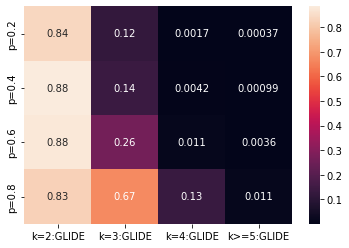

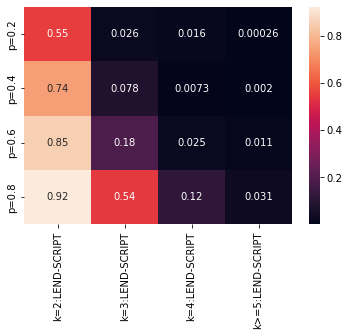

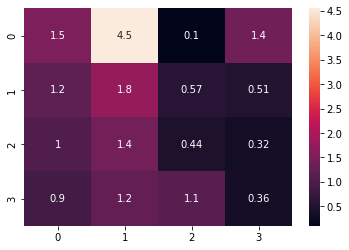

array([[1.52004318, 4.5470918 , 0.10424658, 1.40423325],
       [1.19361087, 1.76564731, 0.57348374, 0.50504634],
       [1.02742477, 1.41483616, 0.44232545, 0.31876376],
       [0.89527405, 1.23248135, 1.14166869, 0.36164516]])

In [41]:
#dfplot = dfsdres.drop([i for i in dfsdres.columns if "D-SCRIPT" in i])
import matplotlib.pyplot as plt
df1 = dfsdres.iloc[:, list([1,4,7,10])]
df2 = dfsdres.iloc[:, list([2,5,8,11])]
df3 = df1.values/df2.values
import seaborn as sns
sns.heatmap(df1, annot = True)
plt.show()

sns.heatmap(df2, annot = True)
plt.show()
sns.heatmap(df3, annot = True)
plt.show()
df3

In [17]:
# Compute the TNR at certain recall positions to see how the two models consider the negatives
recall = [0.05, 0.1, 0.2, 0.3, 0.4]
def compute_fpr_at_recall(tp, fp, recall):
    low_rc  = 0
    high_rc = 0
    low_fp  = 0
    high_fp = 0
    for (rc, fc) in zip(tp, fp):
        if rc >= recall:
            high_rc = rc
            high_fp = fc
            break
        else:
            low_rc  = rc
            low_fc  = fc
    t       = (recall - low_rc) / (high_rc - low_rc)
    fp      = low_fp + t * (high_fp - low_fp)
    return fp

tnrs_g = {}
tnrs_d = {}
for r in recall:
    tnrs_g[r] = {}
    tnrs_d[r] = {}
    for i in ["0.2", "0.4", "0.6", "0.8"]: 
        tnrs_g[r][i] = []
        tnrs_d[r][i] = []
        for j in range(2, 6):
            tnrs_g[r][i].append(compute_tnr_at_recall(gtp[f"{i}:{j}"], gfp[f"{i}:{j}"], r))
            tnrs_d[r][i].append(compute_tnr_at_recall(dtp[f"{i}:{j}"], dfp[f"{i}:{j}"], r))

cols = ["0.2", "0.4", "0.6", "0.8"]
rows = [f"k={k}" for k in range(2,6)]
#! mkdir data/recall_tnr
for r in recall:
    dsets = {f"p={c}" : tnrs_d[r][c] for c in cols}
    gsets = {f"p={c}" : tnrs_g[r][c] for c in cols}
    gframe = pd.DataFrame(gsets, index = rows)
    dframe = pd.DataFrame(dsets, index = rows)
    dframe.to_csv(f"data/recall_tnr/dscript_tnr_{r}.tsv", sep = "\t")
    gframe.to_csv(f"data/recall_tnr/glide_tnr_{r}.tsv", sep  = "\t")
    print(dframe)

        p=0.2     p=0.4     p=0.6     p=0.8
k=2  0.998946  0.988721  0.986034  0.989426
k=3  0.996812  0.994637  0.999160  0.996020
k=4  0.997824  0.994359  0.999787  0.993051
k=5  0.992139  0.992173  0.997333  0.999423
        p=0.2     p=0.4     p=0.6     p=0.8
k=2  0.976188  0.981889  0.960407  0.987722
k=3  0.999032  0.989011  0.995888  0.986029
k=4  0.996509  0.987698  0.999298  0.983847
k=5  0.998209  0.976269  0.996946  0.997713
        p=0.2     p=0.4     p=0.6     p=0.8
k=2  0.970301  0.935992  0.985455  0.914177
k=3  0.988832  0.975055  0.954407  0.958817
k=4  0.997511  0.968139  0.995317  0.955891
k=5  0.989137  0.939891  0.984100  0.986070
        p=0.2     p=0.4     p=0.6     p=0.8
k=2  0.966343  0.987037  0.992992  0.917467
k=3  0.969664  0.909719  0.872762  0.967428
k=4  0.971274  0.919108  0.982596  0.947542
k=5  0.981439  0.957905  0.980744  0.955599
        p=0.2     p=0.4     p=0.6     p=0.8
k=2  0.950055  0.889557  0.984212  0.807766
k=3  0.915474  0.922289  0.95542

In [322]:
rtable = pd.DataFrame(results).T
rtable.columns = ["sd=2", "sd=3", "sd=4", "sd=5"]
rtable
#rtable = pd.DataFrame(results).T
#rtable.columns = [f"d={k+2}" for k in range(7)]
rtable.to_csv("results_sdist.tsv", sep = "\t")

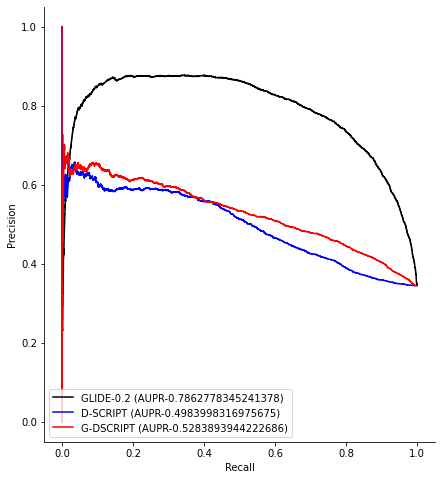

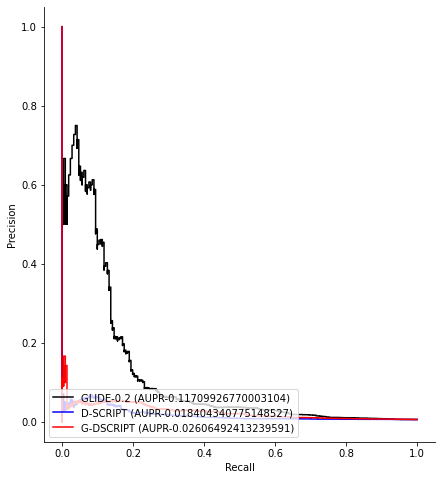

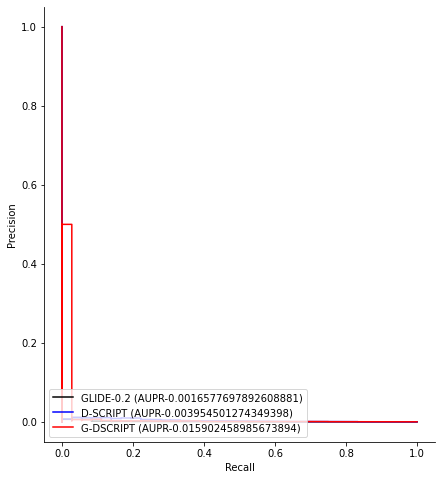

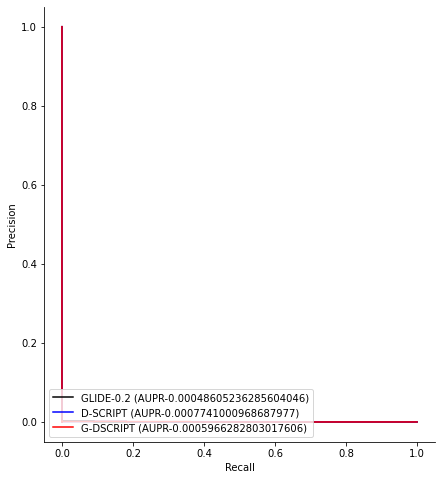

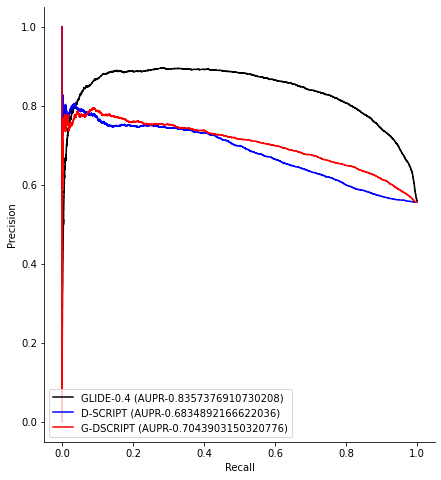

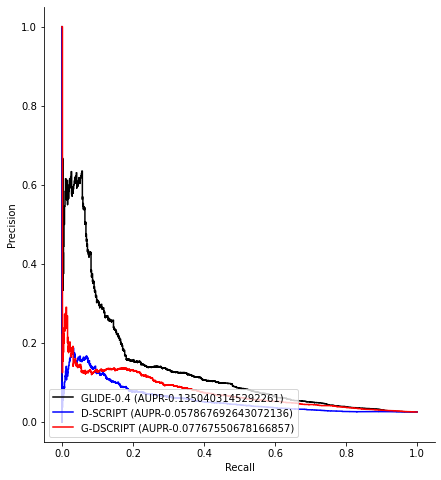

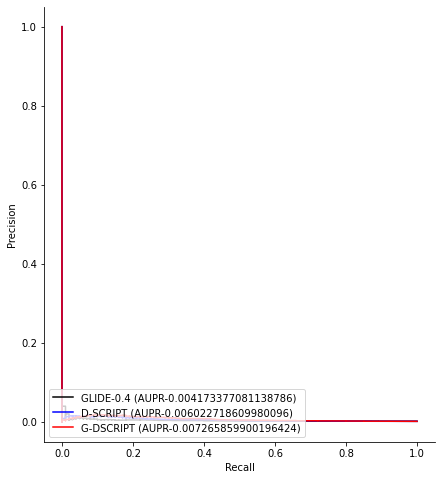

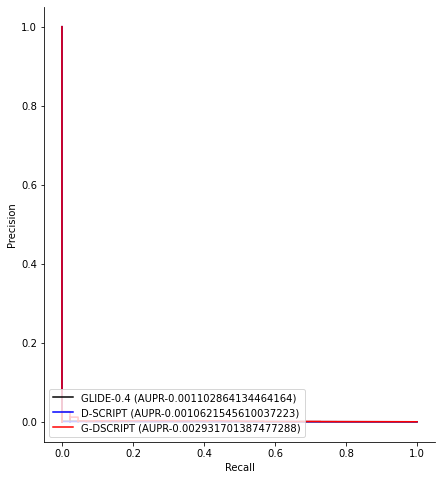

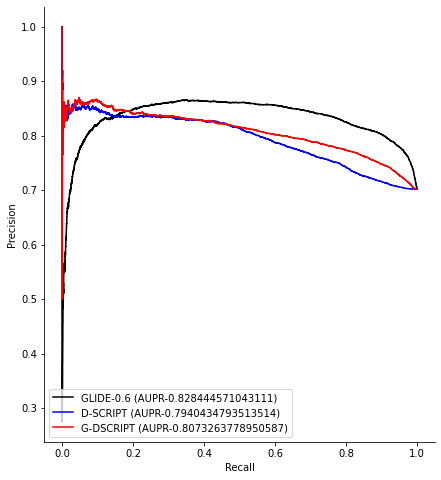

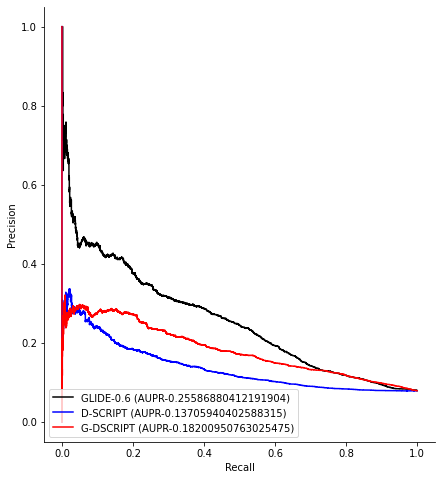

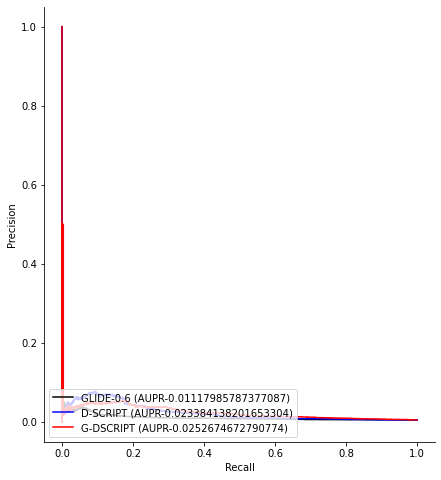

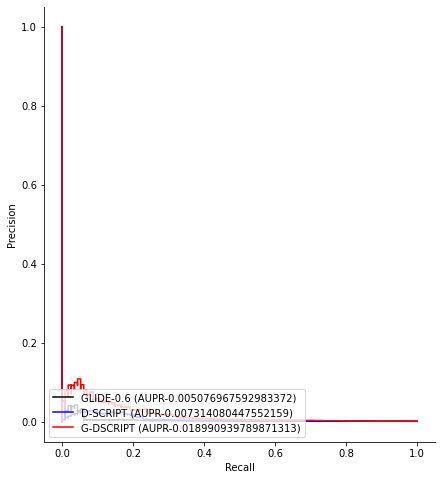

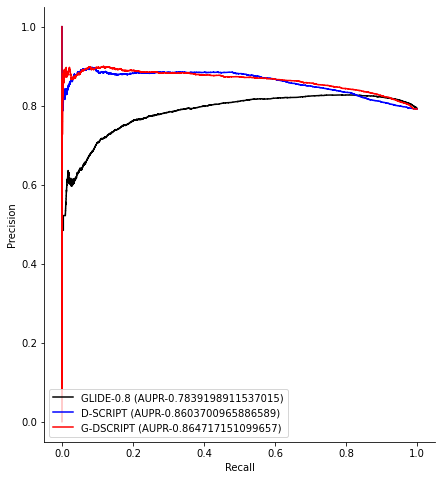

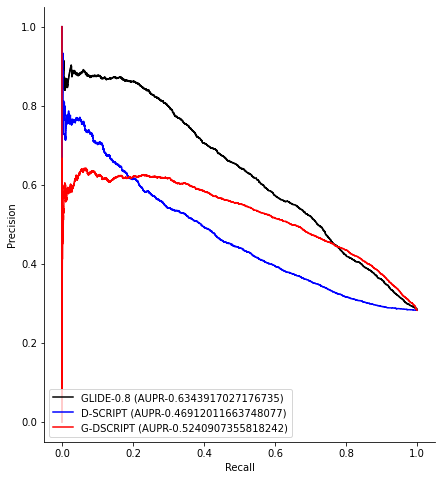

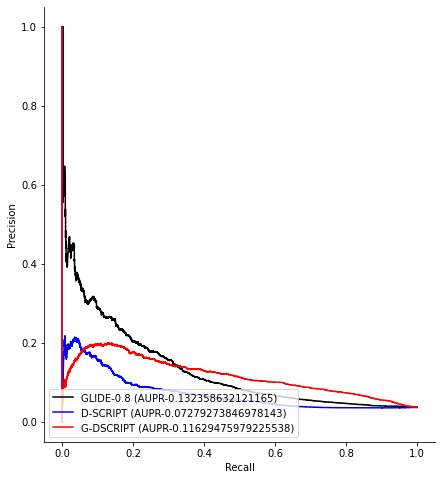

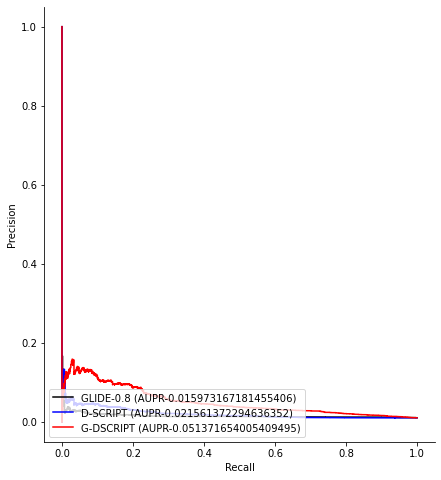

In [67]:
iS  =["0.2", "0.4", "0.6", "0.8"]
sds = range(2,6)
!mkdir data/results/sdist
dir1 = "data/results/sdist"
for i in iS:
    for sd in sds:
        matplotlib.rcParams['pdf.fonttype'] = 42
        matplotlib.rcParams['ps.fonttype'] = 42
        fig = plt.figure(figsize=(7,8)) #whatever size you want
        ax = fig.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        display = PrecisionRecallDisplay(
            recall=grs[f"{i}:{sd}"],
            precision=gps[f"{i}:{sd}"])

        display.plot(ax=ax, name=f'GLIDE-{i} (AUPR-{results[f"GLIDE_{i}"][sd - 2]})', color="black")
        display = PrecisionRecallDisplay(
            recall=drs[f"{i}:{sd}"],
            precision=dps[f"{i}:{sd}"])
        display.plot(ax=ax, name=f'D-SCRIPT (AUPR-{results[f"dscript_{i}"][sd - 2]})', color = "blue")
        display = PrecisionRecallDisplay(
            recall=gdrs[f"{i}:{sd}"],
            precision=gdps[f"{i}:{sd}"])
        display.plot(ax=ax, name=f'G-DSCRIPT (AUPR-{results[f"gdscript_{i}"][sd - 2]})', color = "red")
        fig.savefig(dir1 + f"/aupr_p_{i}_k_{sd}.pdf", bbox_inches="tight")

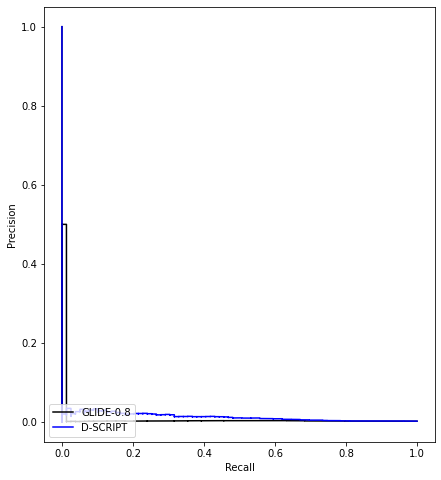

In [70]:
_, ax = plt.subplots(figsize=(7, 8))

prec_glide, rec_glide, prec_dscript, rec_dscript = compute_precision_recall(df_d, 7)
display = PrecisionRecallDisplay(
        recall=rec_glide,
        precision=prec_glide
    )
display.plot(ax=ax, name=f"GLIDE-0.8", color="black")
display = PrecisionRecallDisplay(
        recall=rec_dscript,
        precision=prec_dscript
    )
display.plot(ax=ax, name=f"D-SCRIPT", color = "blue")

## Degree Computations

In [79]:
# for 10 million edges
# select edges that are not in the connected component
# M=0, M=1-10, M=10-20
def compute_min_degree(G, nodes1, nodes2):
    return [min(G.degree(n1), G.degree(n2)) for n1, n2 in zip(nodes1, nodes2)]

def compute_max_degree(G, nodes1, nodes2):
    return [max(G.degree(n1), G.degree(n2)) for n1, n2 in zip(nodes1, nodes2)]

def compute_precision_recall_glide_min(df_d, G, degmin, degmax, i):
    df_min            = df_d.copy()
    df_min["min_deg"] = compute_min_degree(G, df_d["node1"].tolist(), df_d["node2"].tolist())
    df_min            = df_min.loc[df_min["min_deg"].between(degmin, degmax)]
    
    true_scores    = df_min["True_score"].tolist()
    glide_scores   = df_min[f"GLIDE_{i}_score"].tolist()
    prec_glide, rec_glide, _     = precision_recall_curve(true_scores, glide_scores)
    glide_aupr                   = average_precision_score(true_scores, glide_scores)
    return prec_glide, rec_glide, glide_aupr, df_min 

def compute_precision_recall_dscript_min(df_d, G, degmin, degmax):
    df_min            = df_d.copy()
    df_min["min_deg"] = compute_min_degree(G, df_d["node1"].tolist(), df_d["node2"].tolist())
    df_min            = df_min.loc[df_min["min_deg"].between(degmin, degmax)]
    
    true_scores  = df_min["True_score"].tolist()
    dscript_scores = df_min["DSCRIPT-score"].tolist()
    prec_dscript, rec_dscript, _ = precision_recall_curve(true_scores, dscript_scores)
    dscript_aupr                 = average_precision_score(true_scores, dscript_scores)
    return prec_dscript, rec_dscript, dscript_aupr, df_min


def compute_precision_recall_gdscript_min(df_d, G, degmin, degmax):
    df_min            = df_d.copy()
    df_min["min_deg"] = compute_min_degree(G, df_d["node1"].tolist(), df_d["node2"].tolist())
    df_min            = df_min.loc[df_min["min_deg"].between(degmin, degmax)]
    
    true_scores  = df_min["True_score"].tolist()
    dscript_scores = df_min["G-DSCRIPT-score"].tolist()
    prec_dscript, rec_dscript, _ = precision_recall_curve(true_scores, dscript_scores)
    dscript_aupr                 = average_precision_score(true_scores, dscript_scores)
    return prec_dscript, rec_dscript, dscript_aupr, df_min

def compute_precision_recall_glide_max(df_d, G, degmin, degmax, i):
    df_max            = df_d.copy()
    df_max["max_deg"] = compute_max_degree(G, df_d["node1"].tolist(), df_d["node2"].tolist())
    df_max            = df_max.loc[df_max["max_deg"].between(degmin, degmax)]
    
    true_scores    = df_max["True_score"].tolist()
    glide_scores   = df_max[f"GLIDE_{i}_score"].tolist()
    prec_glide, rec_glide, _     = precision_recall_curve(true_scores, glide_scores)
    glide_aupr                   = average_precision_score(true_scores, glide_scores)
    return prec_glide, rec_glide, glide_aupr, df_max

def compute_precision_recall_dscript_max(df_d, G, degmin, degmax):
    df_max            = df_d.copy()
    df_max["max_deg"] = compute_max_degree(G, df_d["node1"].tolist(), df_d["node2"].tolist())
    df_max            = df_max.loc[df_max["max_deg"].between(degmin, degmax)]
    
    true_scores    = df_max["True_score"].tolist()
    dscript_scores = df_max["DSCRIPT-score"].tolist()
    prec_dscript, rec_dscript, _ = precision_recall_curve(true_scores, dscript_scores)
    dscript_aupr                 = average_precision_score(true_scores, dscript_scores)
    return prec_dscript, rec_dscript, dscript_aupr, df_max
_, _, aupr, _ = compute_precision_recall_glide_min(dfs["0.2"], Gs["0.2"], 10, 50, "0.2")
_, _, aupr, _ = compute_precision_recall_dscript_min(dfs["0.8"], Gs["0.8"], 2, 1000)


def compute_precision_recall_gdscript_max(df_d, G, degmin, degmax):
    df_max            = df_d.copy()
    df_max["max_deg"] = compute_max_degree(G, df_d["node1"].tolist(), df_d["node2"].tolist())
    df_max            = df_max.loc[df_max["max_deg"].between(degmin, degmax)]
    
    true_scores    = df_max["True_score"].tolist()
    dscript_scores = df_max["G-DSCRIPT-score"].tolist()
    prec_dscript, rec_dscript, _ = precision_recall_curve(true_scores, dscript_scores)
    dscript_aupr                 = average_precision_score(true_scores, dscript_scores)
    return prec_dscript, rec_dscript, dscript_aupr, df_max
_, _, aupr, _ = compute_precision_recall_glide_min(dfs["0.2"], Gs["0.2"], 10, 50, "0.2")
_, _, aupr, _ = compute_precision_recall_dscript_min(dfs["0.8"], Gs["0.8"], 2, 1000)
aupr

0.49310682727358374

In [46]:
ds = [(1,5), (6,10), (11, 20), (21, 200000)]
rdegree = {"DSCRIPT-min":[], "G-DSCRIPT-min":[], "DSCRIPT-max":[], "G-DSCRIPT-max":[]}
for d_min, d_max in ds:
    _, _, aupr_gd, _ = compute_precision_recall_gdscript_min(df, Gs["complete"], d_min, d_max)
    _, _, aupr_d, _ = compute_precision_recall_dscript_min(df, Gs["complete"], d_min, d_max)
    rdegree["DSCRIPT-min"].append(aupr_d)
    rdegree["G-DSCRIPT-min"].append(aupr_gd)
    _, _, aupr_gd, _ = compute_precision_recall_gdscript_max(df, Gs["complete"], d_min, d_max)
    _, _, aupr_d, _ = compute_precision_recall_dscript_max(df, Gs["complete"], d_min, d_max)
    rdegree["DSCRIPT-max"].append(aupr_d)
    rdegree["G-DSCRIPT-max"].append(aupr_gd)
degres = pd.DataFrame(rdegree, index=["d1-5", "d6-10", "d11-20", "d21-"])
degres.to_csv("Tables/complete_degrees.tsv", sep = "\t")

For p = 0.2, and degrees: (1, 5)
Number of D-SCRIPT Negatives: 199161, Positives: 523
Number of G-DSCRIPT Negatives: 199161, Positives: 523
Number of GLIDE    Negatives: 199161, Positives: 523
For p = 0.2, and degrees: (6, 10)
Number of D-SCRIPT Negatives: 37225, Positives: 621
Number of G-DSCRIPT Negatives: 37225, Positives: 621
Number of GLIDE    Negatives: 37225, Positives: 621
For p = 0.2, and degrees: (11, 20)
Number of D-SCRIPT Negatives: 19646, Positives: 806
Number of G-DSCRIPT Negatives: 19646, Positives: 806
Number of GLIDE    Negatives: 19646, Positives: 806
For p = 0.2, and degrees: (21, 20000)
Number of D-SCRIPT Negatives: 11141, Positives: 3135
Number of G-DSCRIPT Negatives: 11141, Positives: 3135
Number of GLIDE    Negatives: 11141, Positives: 3135
For p = 0.4, and degrees: (1, 5)
Number of D-SCRIPT Negatives: 215280, Positives: 1516
Number of G-DSCRIPT Negatives: 215280, Positives: 1516
Number of GLIDE    Negatives: 215280, Positives: 1516
For p = 0.4, and degrees: (6, 

D-SCRIPT-d=(1,5)  GLIDE-d=(1,5)  LEND-SCRIPT-d=(1,5)  \
p=0.8          0.007378       0.220381             0.017134   
p=0.6          0.020567       0.331073             0.054206   
p=0.4          0.042797       0.454343             0.110450   
p=0.2          0.165064       0.597129             0.323313   

       D-SCRIPT-d=(6,10)  GLIDE-d=(6,10)  LEND-SCRIPT-d=(6,10)  \
p=0.8           0.041133        0.628558              0.090866   
p=0.6           0.098784        0.757185              0.200736   
p=0.4           0.305478        0.863898              0.446349   
p=0.2           0.771896        0.945500              0.810846   

       D-SCRIPT-d=(11,20)  GLIDE-d=(11,20)  LEND-SCRIPT-d=(11,20)  \
p=0.8            0.100494         0.774449               0.166266   
p=0.6            0.292752         0.918448               0.395797   
p=0.4            0.578447         0.940379               0.650506   
p=0.2            0.905318         0.989990               0.932507   

       D-SCRIPT-d=(21-)  GLIDE-d=(21-)  LEND-SCRIPT-d=(21-)  
p=0.8          0.518444       0.953767             0.575344  
p=0.6          0.726672       0.974714             0.768541  
p=0.4          0.876745       0.988348             0.888444  
p=0.2          0.848424       0.930072             0.873531

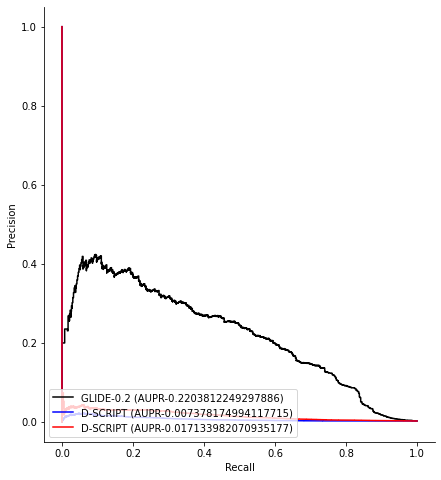

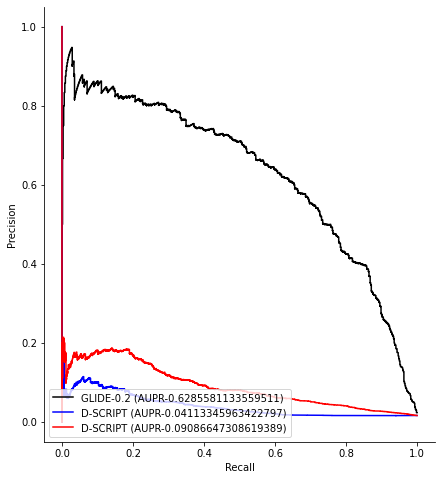

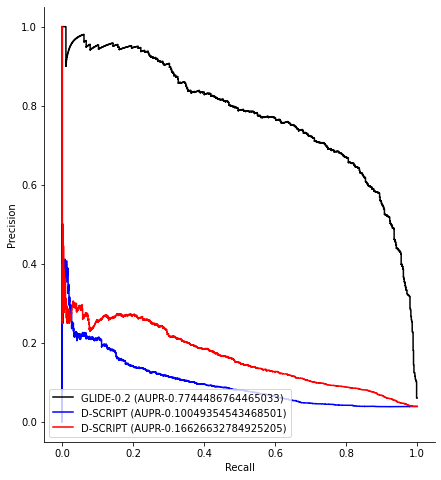

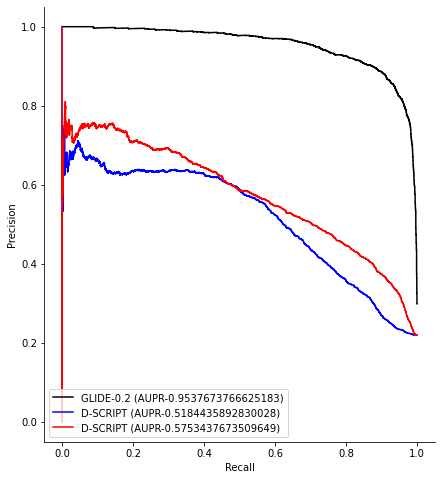

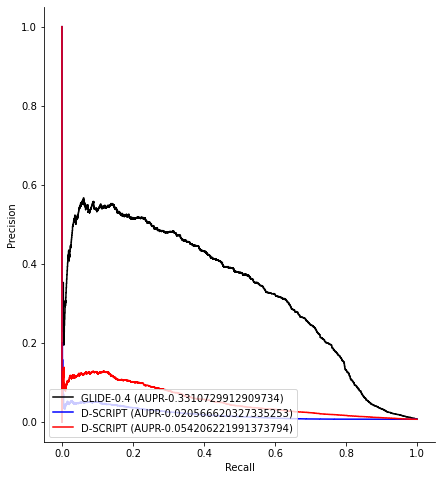

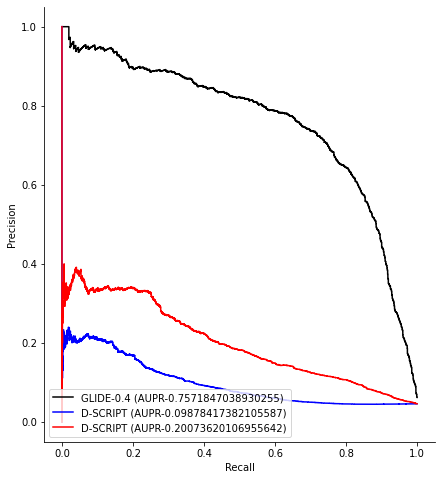

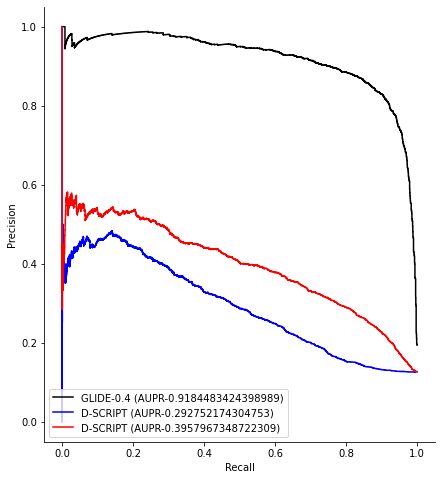

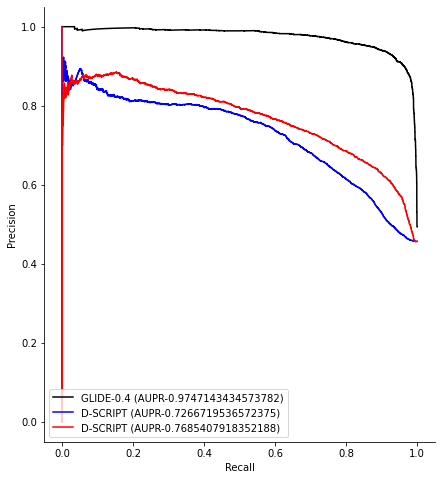

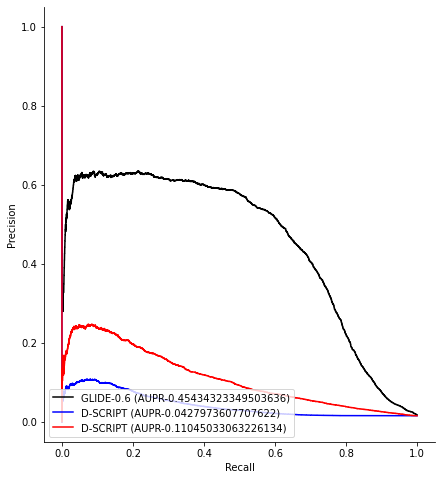

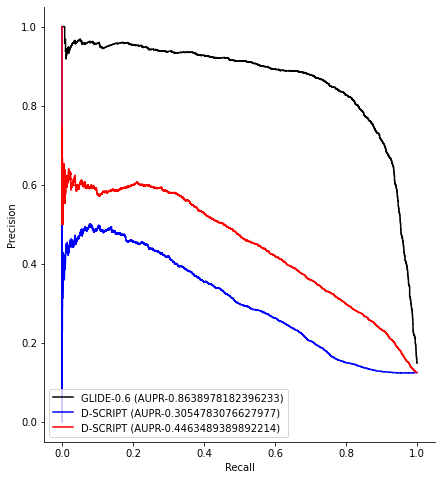

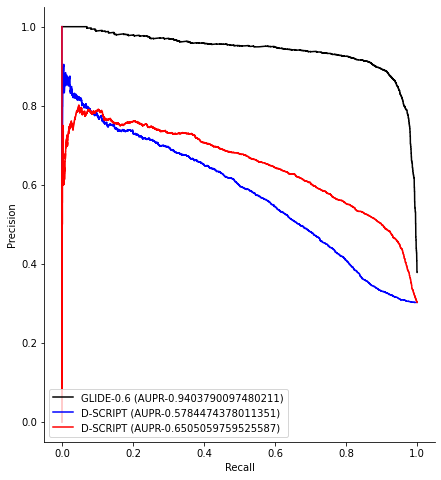

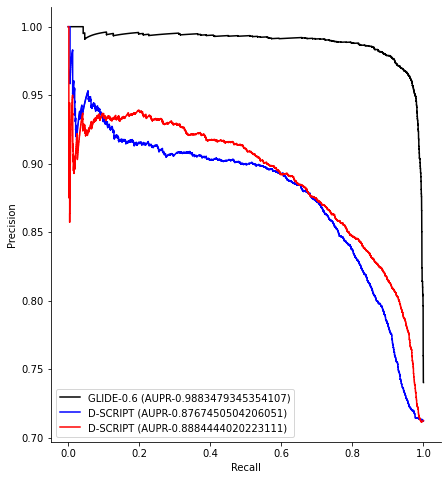

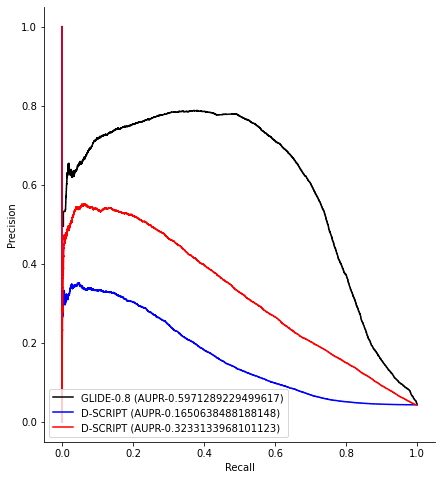

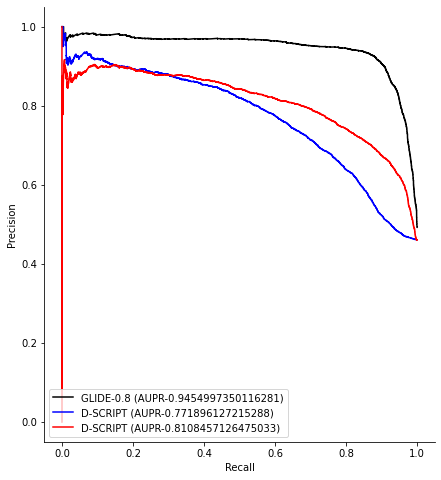

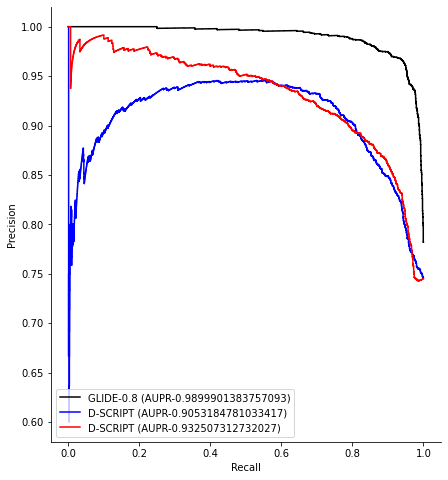

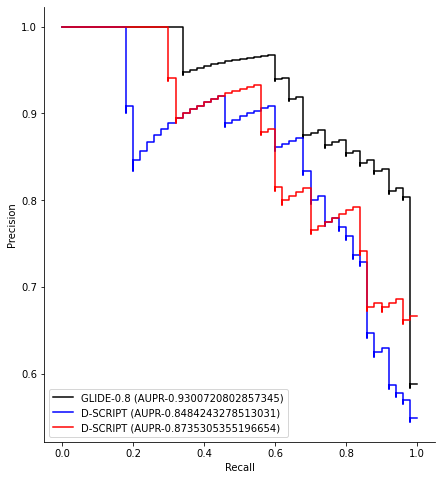

In [88]:
import matplotlib.pyplot as plt
import matplotlib
iss =["0.2", "0.4", "0.6", "0.8"]
ds  = [(1, 5), (6, 10), (11, 20), (21, 20000)]

#! mkdir data/results/pr_degrees
#dir1 = "data/results/pr_degrees"

dinfo = {"D-SCRIPT-d=(1,5)": [], "GLIDE-d=(1,5)": [], "LEND-SCRIPT-d=(1,5)": [],
         "D-SCRIPT-d=(6,10)": [], "GLIDE-d=(6,10)": [], "LEND-SCRIPT-d=(6,10)": [],
         "D-SCRIPT-d=(11,20)": [], "GLIDE-d=(11,20)": [], "LEND-SCRIPT-d=(11,20)": [],
         "D-SCRIPT-d=(21-)": [], "GLIDE-d=(21-)": [], "LEND-SCRIPT-d=(21-)": []}

gres = {}
dres = {}
gdres = {}
for i in iss:
    gres[f"p={i}, pos"] = []
    gres[f"p={i}, neg"] = []
    
    dres[f"p={i}, pos"] = []
    dres[f"p={i}, neg"] = []
    
    gdres[f"p={i}, pos"] = []
    gdres[f"p={i}, neg"] = []
    for d_min, d_max in ds:
        print(f"For p = {i}, and degrees: ({d_min}, {d_max})")
        gp, gr, gaupr, gdf = compute_precision_recall_glide_min(dfs[i], Gs[i], d_min, d_max, i)
        dp, dr, daupr, ddf = compute_precision_recall_dscript_min(dfs[i], Gs[i], d_min, d_max)
        gdp, gdr, gdaupr, gddf = compute_precision_recall_gdscript_min(dfs[i], Gs[i], d_min, d_max)
        
        if d_max > 10000:
            suf = "-d=(21-)"
        else:
            suf = f"-d=({d_min},{d_max})"
        
        dinfo[f"D-SCRIPT{suf}"].append(daupr)
        dinfo[f"GLIDE{suf}"].append(gaupr)
        dinfo[f"LEND-SCRIPT{suf}"].append(gdaupr)
        n_ddf = len(ddf.loc[ddf["True_score"] == 0])
        p_ddf = len(ddf.loc[ddf["True_score"] == 1])

        n_gdf = len(gdf.loc[gdf["True_score"] == 0])
        p_gdf = len(gdf.loc[gdf["True_score"] == 1])
        
        n_gddf = len(gddf.loc[gddf["True_score"] == 0])
        p_gddf = len(gddf.loc[gddf["True_score"] == 1])

        print(f"Number of D-SCRIPT Negatives: {n_ddf}, Positives: {p_ddf}")
        print(f"Number of G-DSCRIPT Negatives: {n_gddf}, Positives: {p_gddf}")
        print(f"Number of GLIDE    Negatives: {n_gdf}, Positives: {p_gdf}")

        gres[f"p={i}, pos"].append(p_gdf)
        gres[f"p={i}, neg"].append(n_ddf)
    
        dres[f"p={i}, pos"].append(p_ddf)
        dres[f"p={i}, neg"].append(n_ddf)
        
        gdres[f"p={i}, pos"].append(p_gddf)
        gdres[f"p={i}, neg"].append(n_gddf)
        
        matplotlib.rcParams['pdf.fonttype'] = 42
        matplotlib.rcParams['ps.fonttype'] = 42
        fig = plt.figure(figsize=(7,8)) #whatever size you want
        ax = fig.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # whatever plotting code you're using goes here: sns.pointplot(ax=ax, x="capacity", y="value", hue="type", data=ldf[ldf["sp"]==sp], dodge=True, join=True, markers='.', s=2, lw=1)
        display = PrecisionRecallDisplay(
            recall=gr,
            precision=gp)
        display.plot(ax=ax, name=f'GLIDE-{i} (AUPR-{gaupr})', color="black")
        display = PrecisionRecallDisplay(
            recall=dr,
            precision=dp)
        display.plot(ax=ax, name=f'D-SCRIPT (AUPR-{daupr})', color = "blue")
        display = PrecisionRecallDisplay(
            recall=gdr,
            precision=gdp)
        display.plot(ax=ax, name=f'D-SCRIPT (AUPR-{gdaupr})', color = "red")
#        fig.savefig(dir1 + f"/pr_p_{i}_degs_{d_min}_{d_max}_min.pdf", bbox_inches="tight")
#degdf = pd.DataFrame(dres, index = [f"degs={dss}" for dss in ds])
#deggf = pd.DataFrame(gres, index = [f"degs={dss}" for dss in ds])
#deggdf = pd.DataFrame(gdres, index = [f"degs={dss}" for dss in ds])
#degdf.to_csv("data/results/pr_degrees/dscript_min.tsv", sep = "\t")
#deggf.to_csv("data/results/pr_degrees/glide_min.tsv", sep = "\t")
#deggdf.to_csv("data/results/pr_degrees/gdscript_min.tsv", sep = "\t")
degreeds = pd.DataFrame(dinfo, index = ["p=0.8", "p=0.6", "p=0.4", "p=0.2"])
degreeds

In [90]:
degreeds.to_csv("Tables/degree_min_res.tsv", sep = "\t")

For p = 0.2, and degrees: (1, 5)
Number of D-SCRIPT Negatives: 65051, Positives: 119
Number of G-DSCRIPT Negatives: 65051, Positives: 119
Number of GLIDE    Negatives: 65051, Positives: 119
For p = 0.2, and degrees: (6, 10)
Number of D-SCRIPT Negatives: 50081, Positives: 257
Number of G-DSCRIPT Negatives: 50081, Positives: 257
Number of GLIDE    Negatives: 50081, Positives: 257
For p = 0.2, and degrees: (11, 20)
Number of D-SCRIPT Negatives: 51559, Positives: 543
Number of G-DSCRIPT Negatives: 51559, Positives: 543
Number of GLIDE    Negatives: 51559, Positives: 543
For p = 0.2, and degrees: (21, 20000)
Number of D-SCRIPT Negatives: 100482, Positives: 4166
Number of G-DSCRIPT Negatives: 100482, Positives: 4166
Number of GLIDE    Negatives: 100482, Positives: 4166
For p = 0.4, and degrees: (1, 5)
Number of D-SCRIPT Negatives: 82938, Positives: 390
Number of G-DSCRIPT Negatives: 82938, Positives: 390
Number of GLIDE    Negatives: 82938, Positives: 390
For p = 0.4, and degrees: (6, 10)
Nu

D-SCRIPT-d=(1,5)  GLIDE-d=(1,5)  LEND-SCRIPT-d=(1,5)  \
p=0.8          0.006965       0.187839             0.020175   
p=0.6          0.015589       0.257241             0.056328   
p=0.4          0.026574       0.361884             0.078243   
p=0.2          0.087936       0.490915             0.221765   

       D-SCRIPT-d=(6,10)  GLIDE-d=(6,10)  LEND-SCRIPT-d=(6,10)  \
p=0.8           0.015497        0.437463              0.039114   
p=0.6           0.033266        0.576964              0.088584   
p=0.4           0.081603        0.633394              0.175510   
p=0.2           0.404776        0.813402              0.553931   

       D-SCRIPT-d=(11,20)  GLIDE-d=(11,20)  LEND-SCRIPT-d=(11,20)  \
p=0.8            0.026590         0.644384               0.059201   
p=0.6            0.086010         0.772956               0.176712   
p=0.4            0.205676         0.857202               0.343376   
p=0.2            0.585121         0.905598               0.696569   

       D-SCRIPT-d=(21-)  GLIDE-d=(21-)  LEND-SCRIPT-d=(21-)  
p=0.8          0.208916       0.905075             0.330164  
p=0.6          0.349405       0.937735             0.492199  
p=0.4          0.507470       0.946531             0.644562  
p=0.2          0.548429       0.837107             0.647179

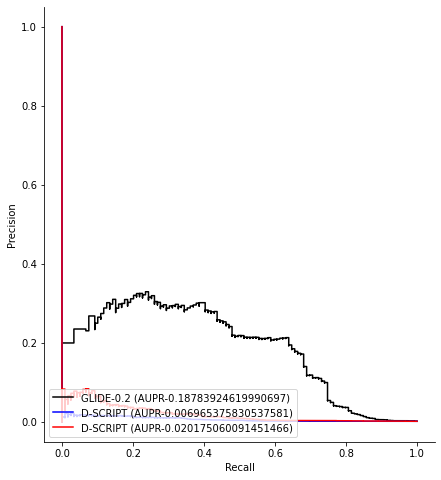

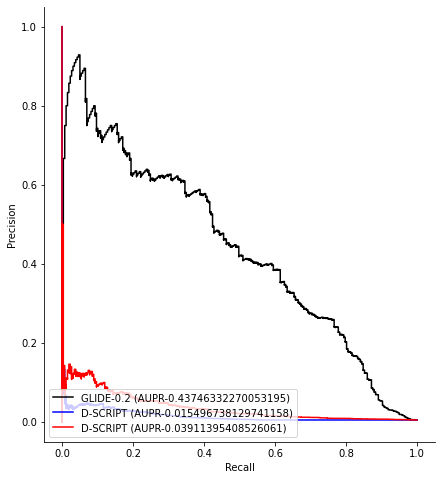

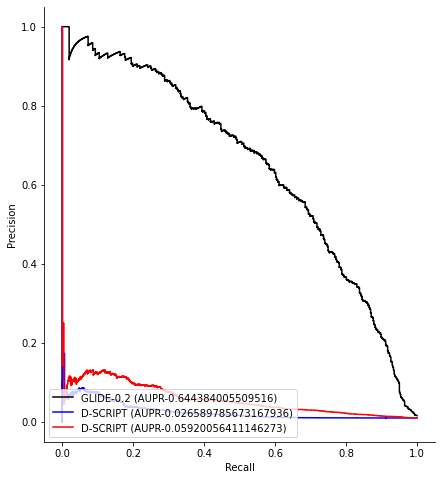

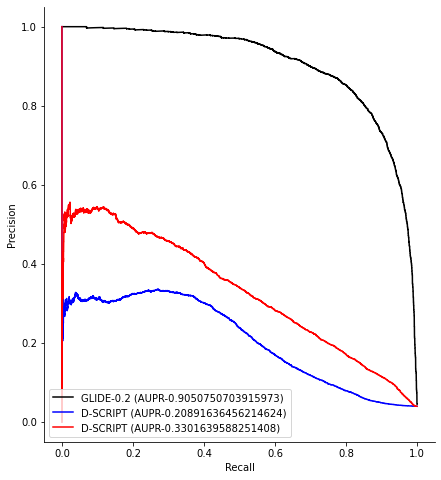

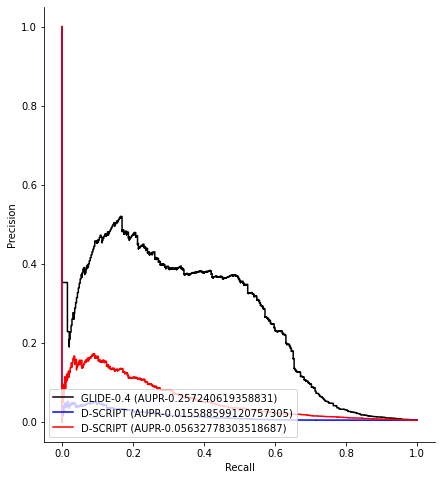

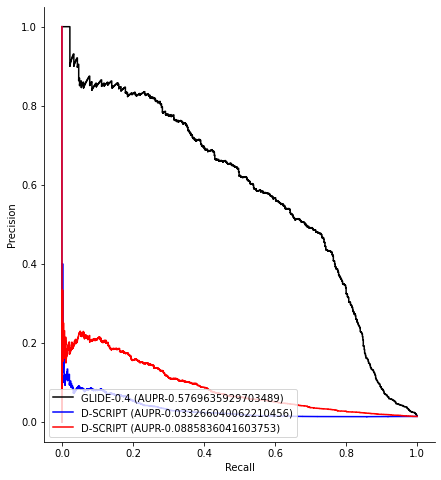

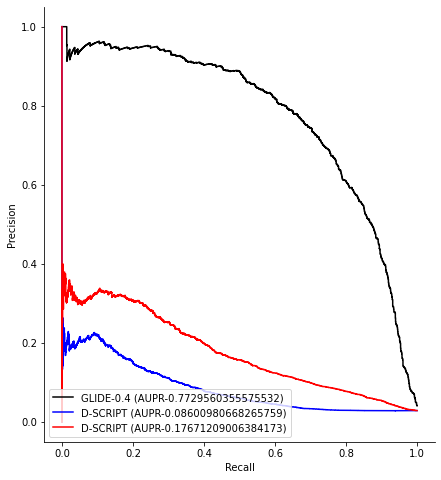

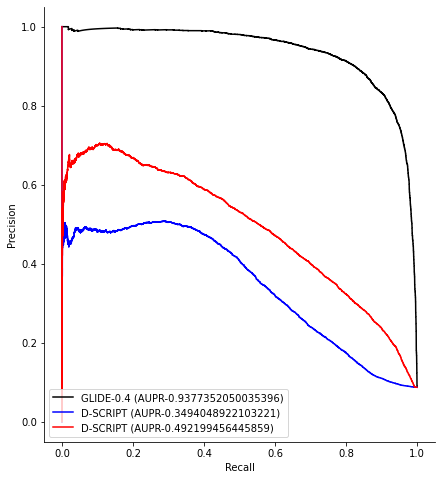

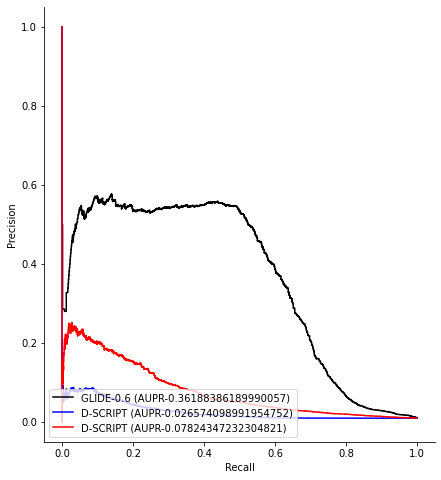

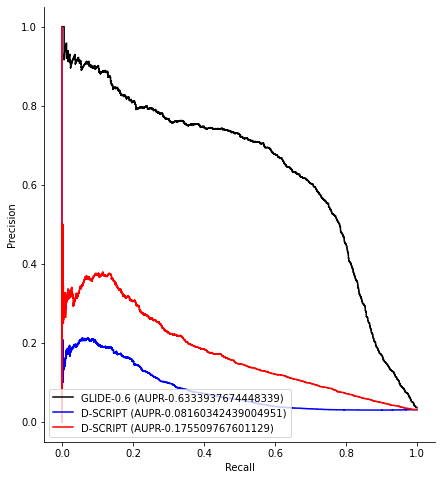

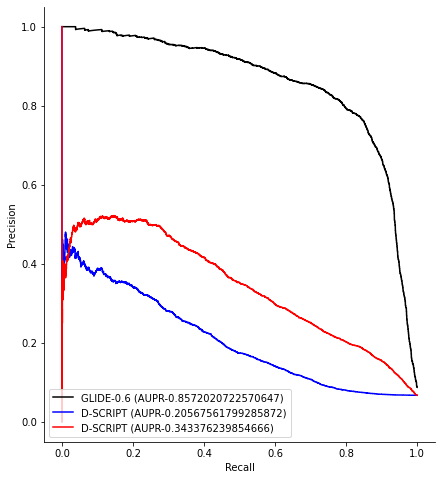

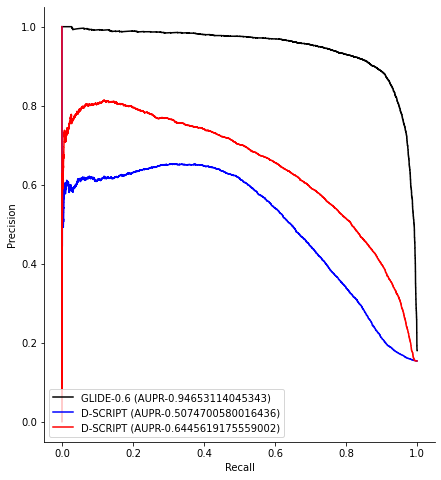

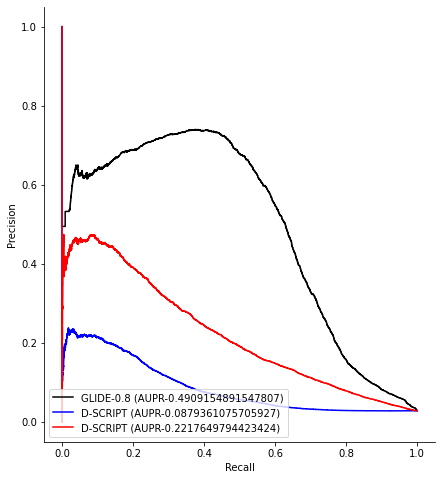

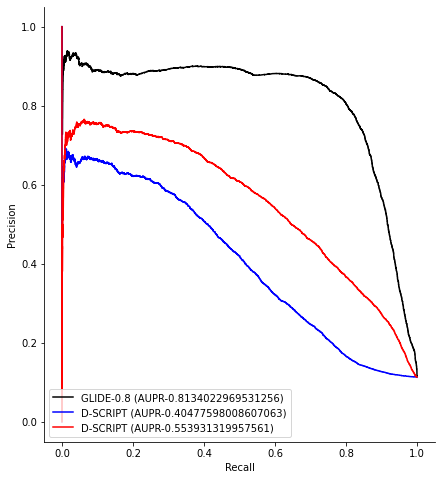

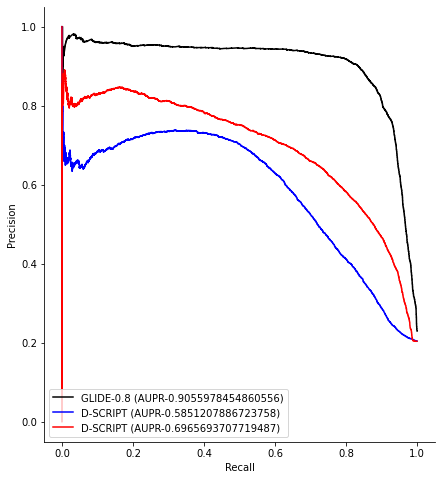

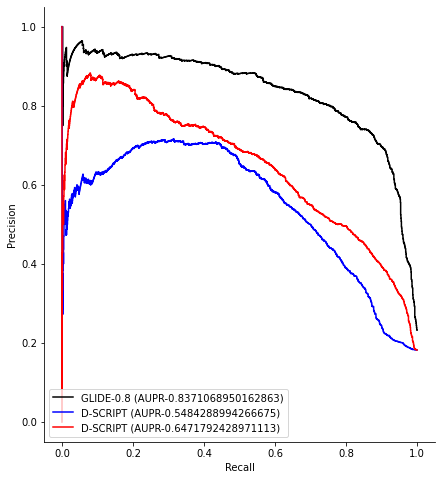

In [93]:
# NODE1 NDOE2 TRUE_VALUE DSCRIPT_PRED
import matplotlib.pyplot as plt
import matplotlib
iss =["0.2", "0.4", "0.6", "0.8"]
ds  = [(1, 5), (6, 10), (11, 20), (21, 20000)]

dinfo = {"D-SCRIPT-d=(1,5)": [], "GLIDE-d=(1,5)": [], "LEND-SCRIPT-d=(1,5)": [],
         "D-SCRIPT-d=(6,10)": [], "GLIDE-d=(6,10)": [], "LEND-SCRIPT-d=(6,10)": [],
         "D-SCRIPT-d=(11,20)": [], "GLIDE-d=(11,20)": [], "LEND-SCRIPT-d=(11,20)": [],
         "D-SCRIPT-d=(21-)": [], "GLIDE-d=(21-)": [], "LEND-SCRIPT-d=(21-)": []}

gres = {}
dres = {}
gdres = {}
for i in iss:
    gres[f"p={i}, pos"] = []
    gres[f"p={i}, neg"] = []
    
    dres[f"p={i}, pos"] = []
    dres[f"p={i}, neg"] = []
    
    gdres[f"p={i}, pos"] = []
    gdres[f"p={i}, neg"] = []
    for d_min, d_max in ds:
        print(f"For p = {i}, and degrees: ({d_min}, {d_max})")
        gp, gr, gaupr, gdf = compute_precision_recall_glide_max(dfs[i], Gs[i], d_min, d_max, i)
        dp, dr, daupr, ddf = compute_precision_recall_dscript_max(dfs[i], Gs[i], d_min, d_max)
        gdp, gdr, gdaupr, gddf = compute_precision_recall_gdscript_max(dfs[i], Gs[i], d_min, d_max)

        n_ddf = len(ddf.loc[ddf["True_score"] == 0])
        p_ddf = len(ddf.loc[ddf["True_score"] == 1])

        n_gdf = len(gdf.loc[gdf["True_score"] == 0])
        p_gdf = len(gdf.loc[gdf["True_score"] == 1])
        
        n_gddf = len(gddf.loc[gddf["True_score"] == 0])
        p_gddf = len(gddf.loc[gddf["True_score"] == 1])

        if d_max > 10000:
            suf = "-d=(21-)"
        else:
            suf = f"-d=({d_min},{d_max})"
        
        dinfo[f"D-SCRIPT{suf}"].append(daupr)
        dinfo[f"GLIDE{suf}"].append(gaupr)
        dinfo[f"LEND-SCRIPT{suf}"].append(gdaupr)
        
        print(f"Number of D-SCRIPT Negatives: {n_ddf}, Positives: {p_ddf}")
        print(f"Number of G-DSCRIPT Negatives: {n_gddf}, Positives: {p_gddf}")
        print(f"Number of GLIDE    Negatives: {n_gdf}, Positives: {p_gdf}")

        gres[f"p={i}, pos"].append(p_gdf)
        gres[f"p={i}, neg"].append(n_ddf)
    
        dres[f"p={i}, pos"].append(p_ddf)
        dres[f"p={i}, neg"].append(n_ddf)
        
        gdres[f"p={i}, pos"].append(p_gddf)
        gdres[f"p={i}, neg"].append(n_gddf)
        
        matplotlib.rcParams['pdf.fonttype'] = 42
        matplotlib.rcParams['ps.fonttype'] = 42
        fig = plt.figure(figsize=(7,8)) #whatever size you want
        ax = fig.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # whatever plotting code you're using goes here: sns.pointplot(ax=ax, x="capacity", y="value", hue="type", data=ldf[ldf["sp"]==sp], dodge=True, join=True, markers='.', s=2, lw=1)
        display = PrecisionRecallDisplay(
            recall=gr,
            precision=gp)
        display.plot(ax=ax, name=f'GLIDE-{i} (AUPR-{gaupr})', color="black")
        display = PrecisionRecallDisplay(
            recall=dr,
            precision=dp)
        display.plot(ax=ax, name=f'D-SCRIPT (AUPR-{daupr})', color = "blue")
        display = PrecisionRecallDisplay(
            recall=gdr,
            precision=gdp)
        display.plot(ax=ax, name=f'D-SCRIPT (AUPR-{gdaupr})', color = "red")
#        fig.savefig(dir1 + f"/pr_p_{i}_degs_{d_min}_{d_max}_max.pdf", bbox_inches="tight")
degreeds = pd.DataFrame(dinfo, index = ["p=0.8", "p=0.6", "p=0.4", "p=0.2"])
degreeds
# degdf = pd.DataFrame(dres, index = [f"degs={dss}" for dss in ds])
# deggf = pd.DataFrame(gres, index = [f"degs={dss}" for dss in ds])
# deggdf = pd.DataFrame(gdres, index = [f"degs={dss}" for dss in ds])
# degdf.to_csv("data/results/pr_degrees/dscript_max.tsv", sep = "\t")
# deggf.to_csv("data/results/pr_degrees/glide_max.tsv", sep = "\t")
# deggdf.to_csv("data/results/pr_degrees/gdscript_max.tsv", sep = "\t")